### Import libs

In [1]:
import json
import nltk

import pandas as pd
from insights import load_data, extract_data, get_insights, plot_histogram, plot_bar_chart
from preprocessing import preprocessed_with_stopwords_with_lemming, preprocessed_without_stopwords_with_lemming, preprocessed_with_stopwords_without_lemming, preprocessed_without_stopwords_without_lemming
from classification import train_and_evaluate_nb, train_and_evaluate_ffnn, load_json_data, prepare_train_test_split, move_samples_between_sets
# pip install scipy==1.12 for word2vec

### Task 1: Extract insights from data

                                                text    category
0  THIS IS MASSIVE Australian Senator Malcolm Rob...  CONSPIRACY
1  “ I ’m deeply concerned that the push to vacci...    CRITICAL
2  2021 : They wanted to know your vaccination st...    CRITICAL
3  Anthony Fauci once again defended brutal Chine...    CRITICAL
4  Proof has emerged showing that death from Wuha...    CRITICAL


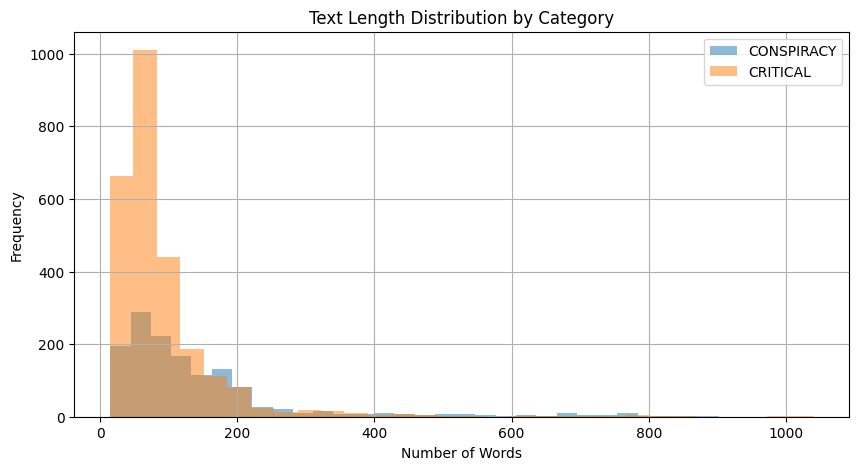

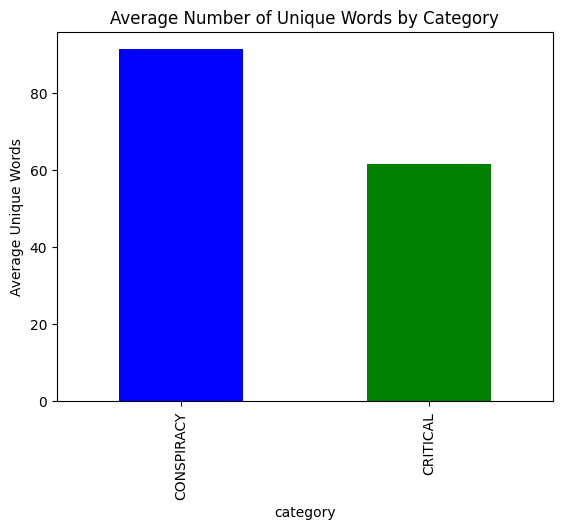

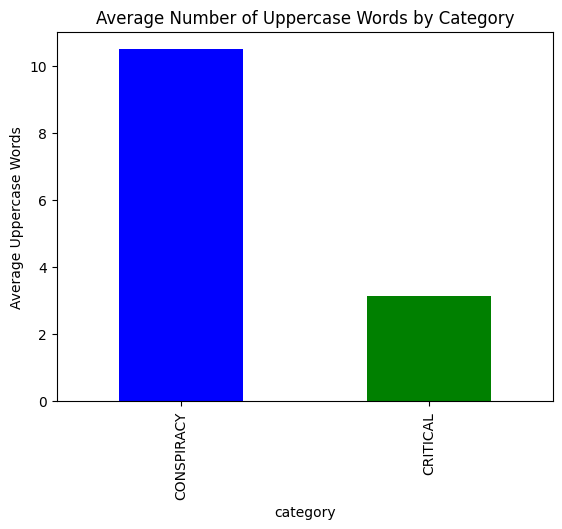

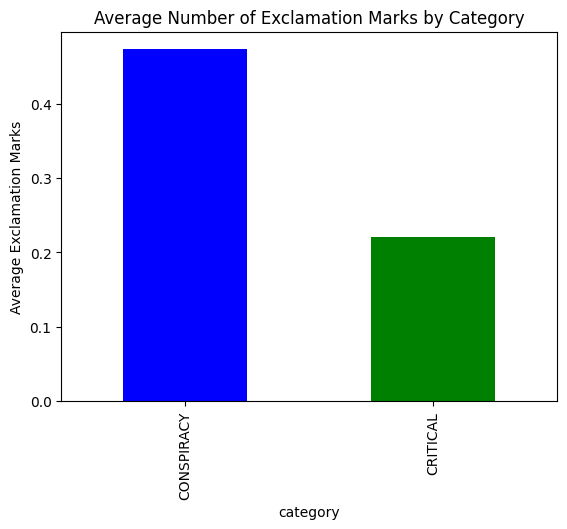

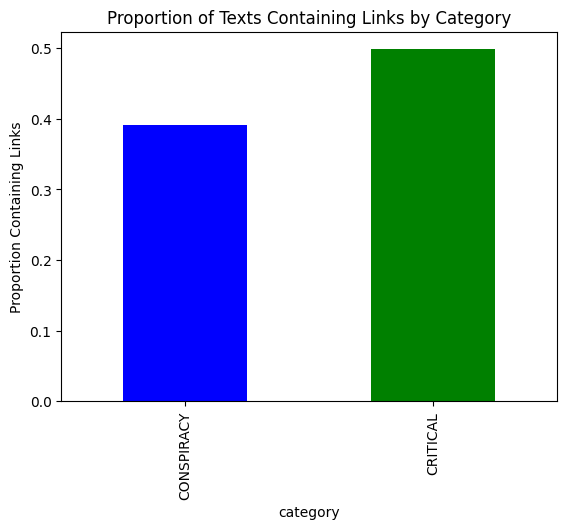

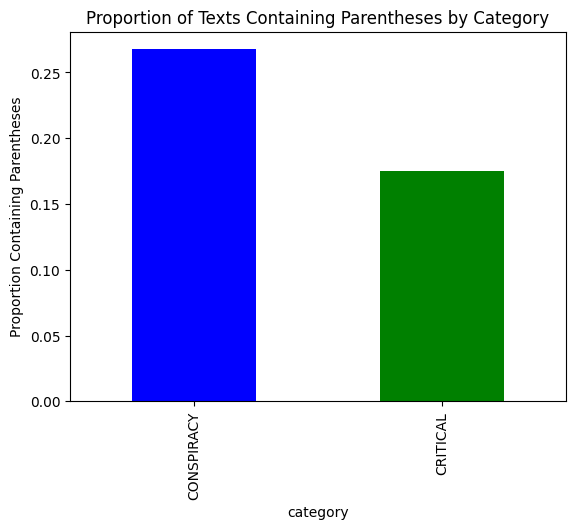

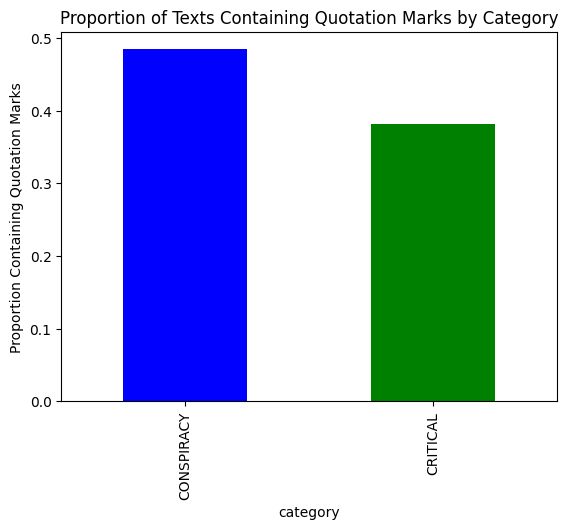

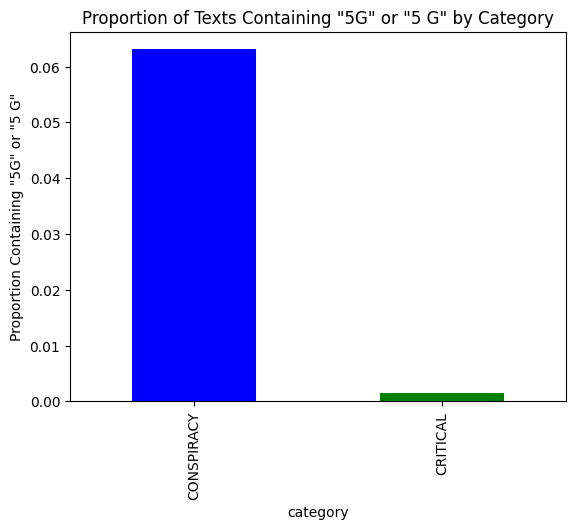

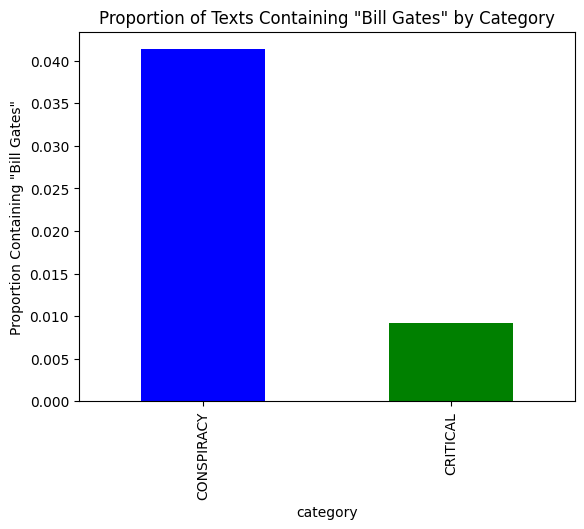

In [2]:
# Load and extract data
data = load_data('Oppositional_thinking_analysis_dataset.json')

# Extract text and category from the data.
data_extracted = extract_data(data)

# Convert to DataFrame
df = pd.DataFrame(data_extracted)
print(df.head())

# Adding new features
df = get_insights(df)

# Plot distributions and bar charts. (df, category, title, xlabel, ylabel):
plot_histogram(df, 'text_length', 'Text Length Distribution by Category', 'Number of Words', 'Frequency')
plot_bar_chart(df, 'unique_word_count', 'Average Number of Unique Words by Category', 'Average Unique Words')
plot_bar_chart(df, 'uppercase_word_count', 'Average Number of Uppercase Words by Category', 'Average Uppercase Words')
plot_bar_chart(df, 'exclamation_count', 'Average Number of Exclamation Marks by Category', 'Average Exclamation Marks')

# Plot feature-based bar charts
plot_bar_chart(df, 'contains_link', 'Proportion of Texts Containing Links by Category', 'Proportion Containing Links')
plot_bar_chart(df, 'contains_parentheses', 'Proportion of Texts Containing Parentheses by Category', 'Proportion Containing Parentheses')
plot_bar_chart(df, 'contains_quotation_marks', 'Proportion of Texts Containing Quotation Marks by Category', 'Proportion Containing Quotation Marks')
plot_bar_chart(df, 'contains_5G', 'Proportion of Texts Containing "5G" or "5 G" by Category', 'Proportion Containing "5G" or "5 G"')
plot_bar_chart(df, 'contains_bill_gates', 'Proportion of Texts Containing "Bill Gates" by Category', 'Proportion Containing "Bill Gates"')

### Task 2: Pre-processing

In [23]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

with open('data/Oppositional_thinking_analysis_dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract text and category
data_extracted = [{'text': entry['text'], 'category': entry['category']} for entry in data]

category_mapping = {
    'CRITICAL': 0,     
    'CONSPIRACY': 1
}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
def preprocess_and_save(data, preprocess_func, file_name):
    df = pd.DataFrame(data)
    df['preprocessed_text'] = df['text'].apply(preprocess_func)
    df = df.drop('text', axis=1)
    df['category'] = df['category'].apply(lambda x: category_mapping[x])
    df.to_json(file_name, orient='records', lines=True, force_ascii=False)
    print(df.head())
    return df

# List of preprocessing configurations
preprocessing_configs = [
    ('preprocessed_with_stopwords_with_lemming', preprocessed_with_stopwords_with_lemming, 'data/preprocessed_with_stopwords_with_lemming.json'),
    ('preprocessed_without_stopwords_with_lemming', preprocessed_without_stopwords_with_lemming, 'data/preprocessed_without_stopwords_with_lemming.json'),
    ('preprocessed_with_stopwords_without_lemming', preprocessed_with_stopwords_without_lemming, 'data/preprocessed_with_stopwords_without_lemming.json'),
    ('preprocessed_without_stopwords_without_lemming', preprocessed_without_stopwords_without_lemming, 'data/preprocessed_without_stopwords_without_lemming.json')
]

# Dictionary to store preprocessed DataFrames
preprocessed_data = {}

# Apply preprocessing and save results
for name, func, file_name in preprocessing_configs:
    preprocessed_data[name] = preprocess_and_save(data_extracted, func, file_name)

   category                                  preprocessed_text
0         1  this is massive australian senator malcolm rob...
1         0  i m deeply concerned that the push to vaccinat...
2         0  two thousand and twentyone they wanted to know...
3         0  anthony fauci once again defended brutal chine...
4         0  proof ha emerged showing that death from wuhan...
   category                                  preprocessed_text
0         1  massive australian senator malcolm robert expo...
1         0  deeply concerned push vaccinate child nothing ...
2         0  two thousand twentyone wanted know vaccination...
3         0  anthony fauci defended brutal chinese lockdown...
4         0  proof emerged showing death wuhan coronavirus ...
   category                                  preprocessed_text
0         1  this is massive australian senator malcolm rob...
1         0  i m deeply concerned that the push to vaccinat...
2         0  two thousand and twentyone they wanted to 

### Task 3: Text classification

#### Load data with different pre-processing steps

In [2]:
# Load the preprocessed JSON data (from Task 2)
data_files = [
    'data/preprocessed_with_stopwords_with_lemming.json',
    'data/preprocessed_without_stopwords_with_lemming.json',
    'data/preprocessed_with_stopwords_without_lemming.json',
    'data/preprocessed_without_stopwords_without_lemming.json'
]

#### Different vectorization Models

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Vectorizers to compare
vectorizers = [
    (CountVectorizer(), 'CountVectorizer'),
    (TfidfVectorizer(), 'TfidfVectorizer'),
    (CountVectorizer(ngram_range=(1, 3)), 'CountVectorizer(ngram_range=(1, 3))')  # Unigrams, Bigrams, and Trigrams
]

#### naïve Bayes model

In [4]:
results = {}

# Iterate over each data file and each vectorizer
for data_file in data_files:
    # Load data
    data = load_json_data(data_file)
    
    # Prepare train and test sets
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "nb")
    
    print(f"\nData file: {data_file}")
    print("Original train set length:", len(X_train))
    print("Original test set length:", len(X_test))
    
    # Move samples of the 'CRITICAL' category (assumed to be labeled as 0)
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    
    print("\nAfter undersampling:")
    print("Train set length:", len(X_train))
    print("Test set length:", len(X_test))

    # Dictionary to store classification reports
    results[data_file] = {}
    
    # Iterate over each vectorizer for this data file
    for vectorizer, vectorizer_name in vectorizers:
        print(100*"*")
        report  = train_and_evaluate_nb(vectorizer, X_train['preprocessed_text'], X_test['preprocessed_text'], y_train, y_test, data_file, vectorizer_name)
        results[data_file][vectorizer_name] = report


Data file: data/preprocessed_with_stopwords_with_lemming.json
Original train set length: 3200
Original test set length: 800

After undersampling:
Train set length: 2450
Test set length: 1550
****************************************************************************************************

File: data/preprocessed_with_stopwords_with_lemming.json | Vectorizer: CountVectorizer
For CountVectorizer():
Number of misclassified examples out of 1550 examples : 281
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1274
           1       0.49      0.84      0.62       276

    accuracy                           0.82      1550
   macro avg       0.73      0.83      0.75      1550
weighted avg       0.88      0.82      0.83      1550

****************************************************************************************************

File: data/preprocessed_with_stopwords_with_lemming.json | Vectorizer: TfidfVectorizer
For TfidfVectorizer(

#### Visualize Bayes Stats


Data file: data/preprocessed_with_stopwords_with_lemming.json

Vectorizer: CountVectorizer


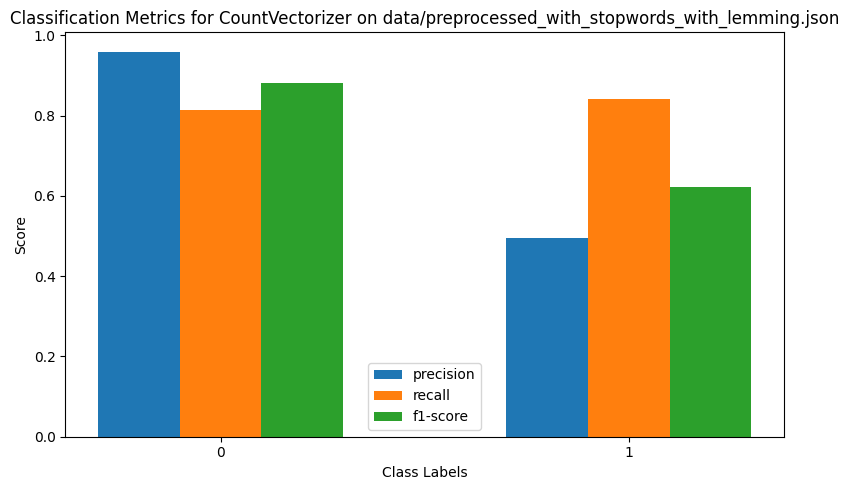


Vectorizer: TfidfVectorizer


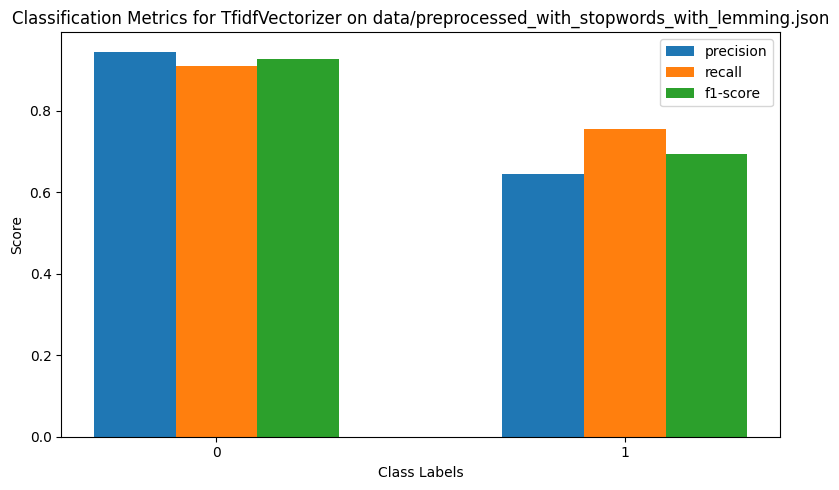


Vectorizer: CountVectorizer(ngram_range=(1, 3))


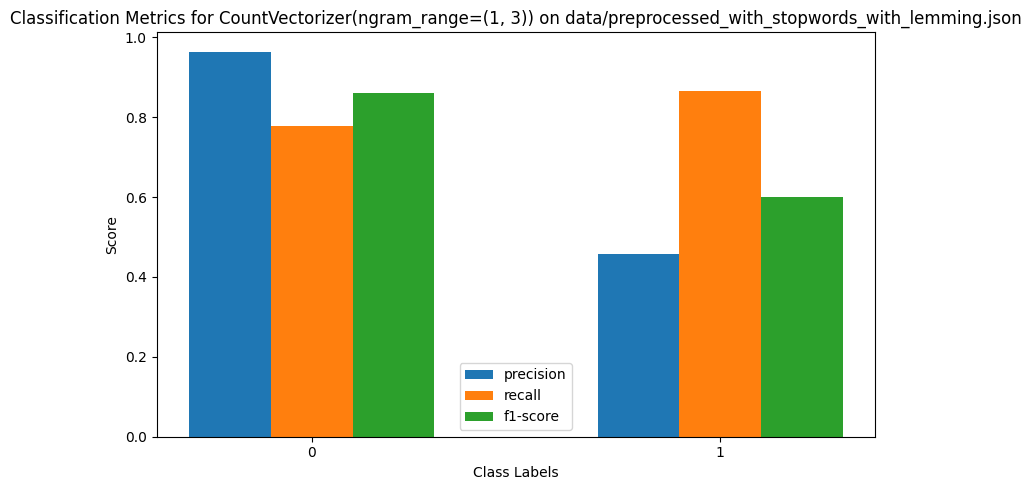


Data file: data/preprocessed_without_stopwords_with_lemming.json

Vectorizer: CountVectorizer


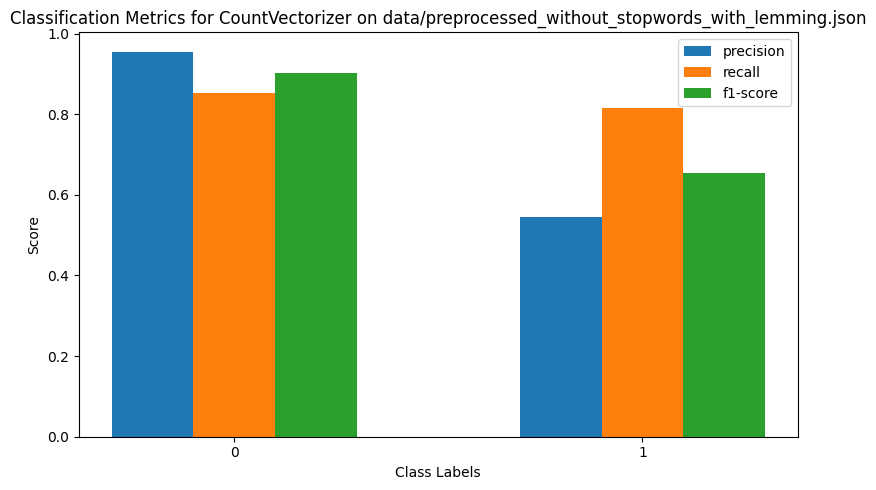


Vectorizer: TfidfVectorizer


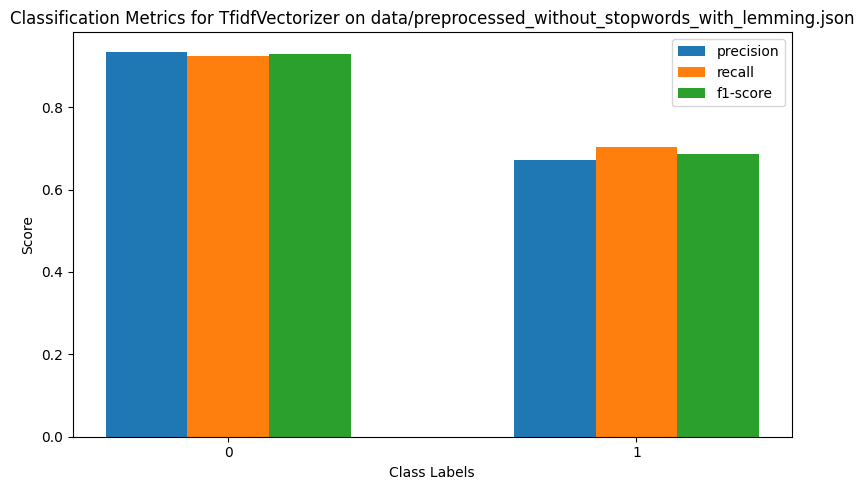


Vectorizer: CountVectorizer(ngram_range=(1, 3))


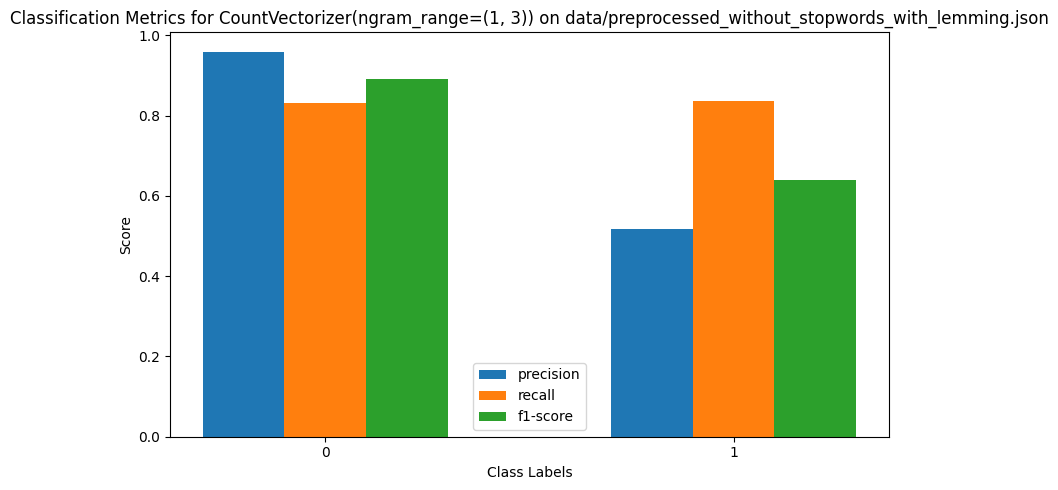


Data file: data/preprocessed_with_stopwords_without_lemming.json

Vectorizer: CountVectorizer


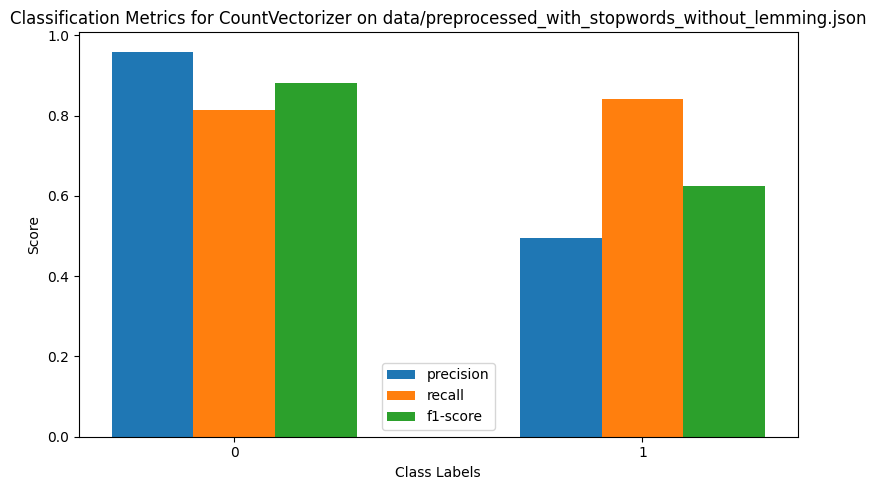


Vectorizer: TfidfVectorizer


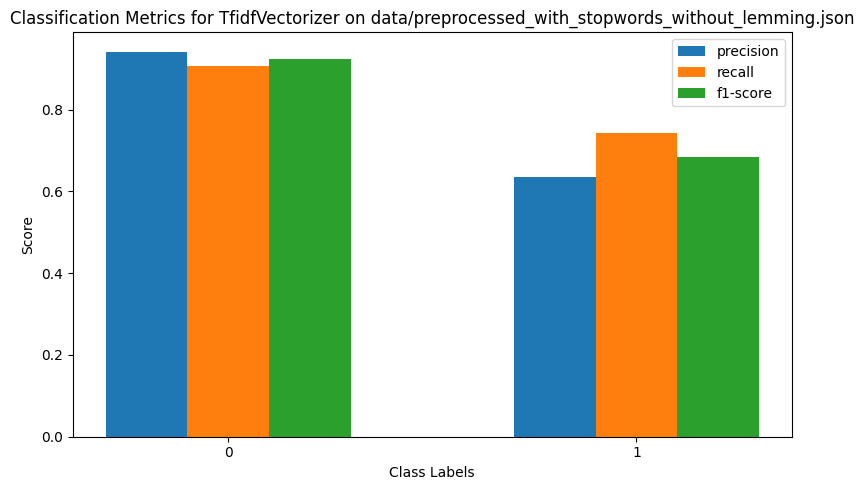


Vectorizer: CountVectorizer(ngram_range=(1, 3))


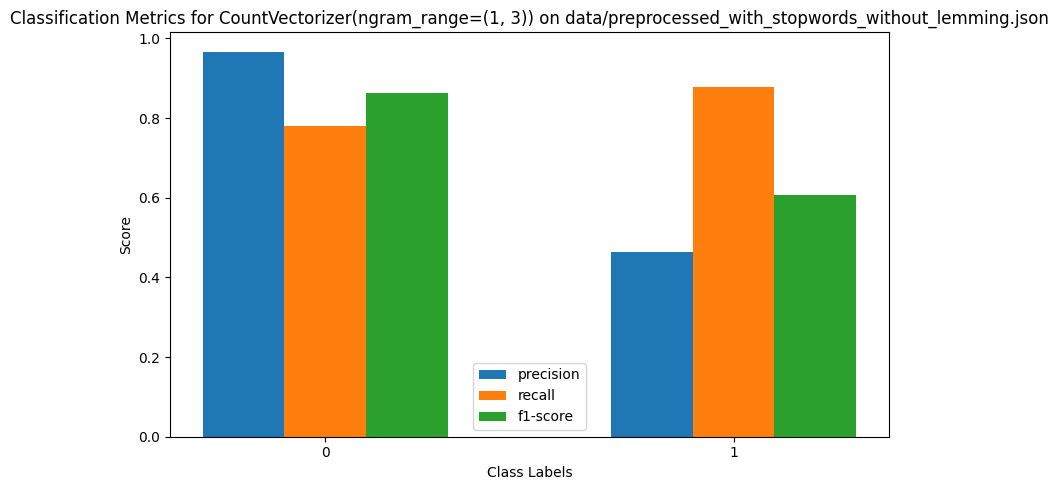


Data file: data/preprocessed_without_stopwords_without_lemming.json

Vectorizer: CountVectorizer


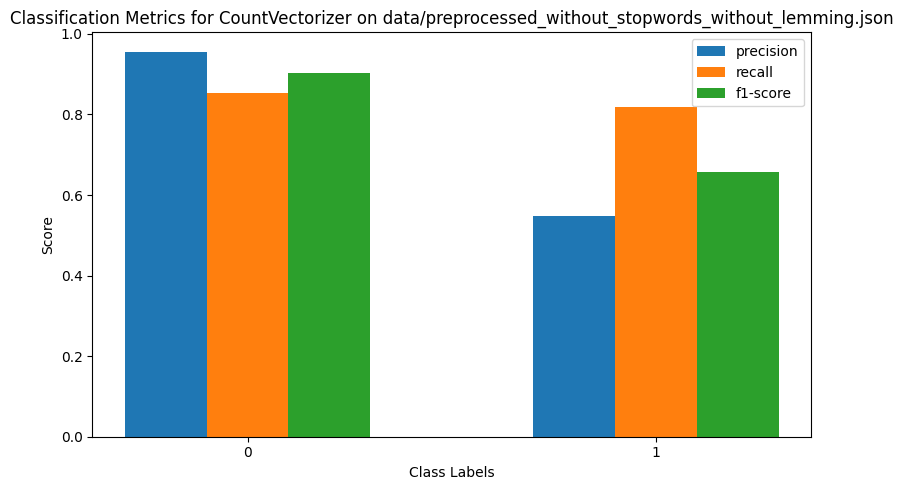


Vectorizer: TfidfVectorizer


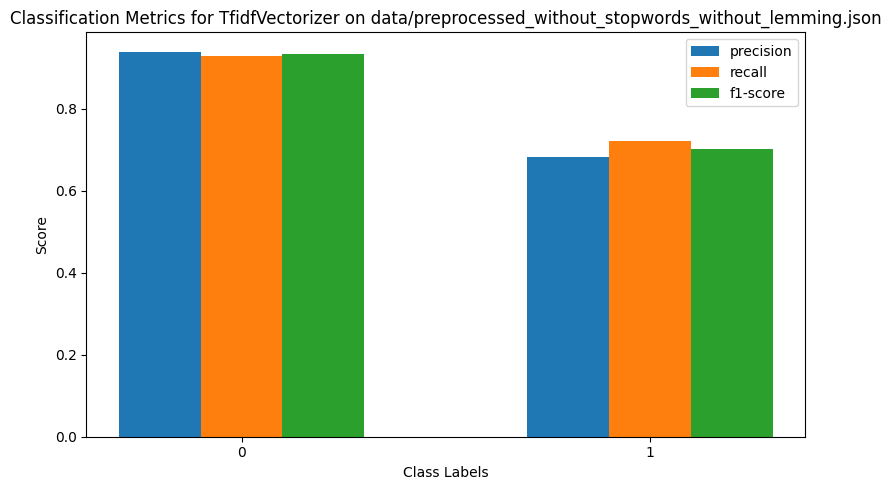


Vectorizer: CountVectorizer(ngram_range=(1, 3))


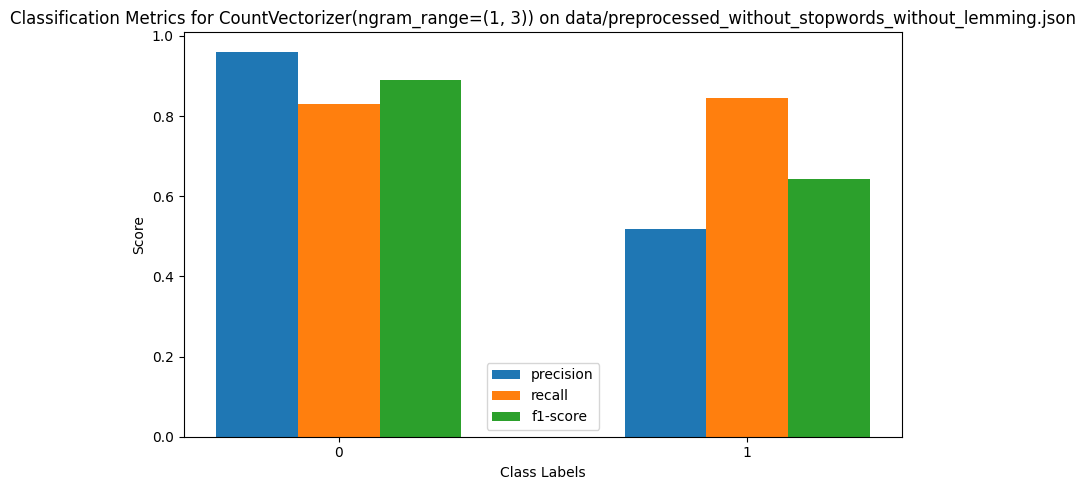

In [34]:
import matplotlib.pyplot as plt

# Visualize results
for data_file, data_results in results.items():
    print(f"\nData file: {data_file}")
    for vectorizer_name, report in data_results.items():
        print(f"\nVectorizer: {vectorizer_name}")
        # Extract precision, recall, f1-score for each class
        labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
        metrics = ['precision', 'recall', 'f1-score']
        values = [[report[label][metric] for metric in metrics] for label in labels]
        
        # Plotting
        fig, ax = plt.subplots(figsize=(8, 5))
        bar_width = 0.2
        index = list(range(len(labels)))
        
        for i, metric in enumerate(metrics):
            ax.bar([idx + i * bar_width for idx in index], [value[i] for value in values], bar_width, label=metric)
        
        ax.set_xlabel('Class Labels')
        ax.set_ylabel('Score')
        ax.set_title(f'Classification Metrics for {vectorizer_name} on {data_file}')
        ax.set_xticks([idx + bar_width for idx in index])
        ax.set_xticklabels(labels)
        ax.legend()
        
        plt.tight_layout()
        plt.show()

#### Error Analysis: naïve Bayes model

#### FFNN Model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Hyperparameters
input_size = 3000  # Adjust based on the vectorizer output size
hidden_size1 = 128
hidden_size2 = 64
output_size = 1
dropout_rate = 0.5
learning_rate = 0.001
batch_size = 32
epochs = 20

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch Dataset class
class TextDataset(Dataset):
    def __init__(self, X, y, vectorizer):
        self.X = X
        self.y = y
        self.vectorizer = vectorizer
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        label = self.y.iloc[idx]
        vectorized_text = self.vectorizer.transform([text]).toarray().squeeze()
        return torch.FloatTensor(vectorized_text), torch.tensor(label, dtype=torch.float32)
    
# FFNN Model class
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Iterate over each data file and each vectorizer
for data_file in data_files:
    data = load_json_data(data_file)
    
    X_train, X_test, y_train, y_test = prepare_train_test_split(data, "ffnn")
    
    X_train, y_train, X_test, y_test = move_samples_between_sets(X_train, y_train, X_test, y_test)
    
    for vectorizer, vectorizer_name in vectorizers:
        X_train_vec = vectorizer.fit_transform(X_train).toarray()
        X_test_vec = vectorizer.transform(X_test).toarray()
        
        # Create datasets and dataloaders
        train_dataset = TextDataset(X_train, y_train, vectorizer)
        test_dataset = TextDataset(X_test, y_test, vectorizer)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        print(f"\nData file: {data_file} | Vectorizer: {vectorizer_name}")
        
        # Initialize model, criterion, and optimizer
        model = FFNN(input_size=X_train_vec.shape[1],
                     hidden_size1=hidden_size1,
                     hidden_size2=hidden_size2,
                     output_size=output_size,
                     dropout_rate=dropout_rate)
        
        model.to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train and evaluate FFNN model
        train_and_evaluate_ffnn(model, train_loader, test_loader, criterion, optimizer, device)



Data file: data/preprocessed_with_stopwords_with_lemming.json | Vectorizer: CountVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 106.33it/s]



F1 Score: 0.6628242074927954
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1274
         1.0       0.55      0.83      0.66       276

    accuracy                           0.85      1550
   macro avg       0.75      0.84      0.78      1550
weighted avg       0.89      0.85      0.86      1550

Confusion Matrix:
[[1086  188]
 [  46  230]]

Data file: data/preprocessed_with_stopwords_with_lemming.json | Vectorizer: TfidfVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 52.86it/s]



F1 Score: 0.6720516962843296
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      1274
         1.0       0.61      0.75      0.67       276

    accuracy                           0.87      1550
   macro avg       0.78      0.82      0.80      1550
weighted avg       0.88      0.87      0.87      1550

Confusion Matrix:
[[1139  135]
 [  68  208]]

Data file: data/preprocessed_with_stopwords_with_lemming.json | Vectorizer: CountVectorizer(ngram_range=(1, 3))


Evaluating: 100%|██████████| 49/49 [00:03<00:00, 14.34it/s]



F1 Score: 0.6875
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      1274
         1.0       0.58      0.84      0.69       276

    accuracy                           0.86      1550
   macro avg       0.77      0.85      0.80      1550
weighted avg       0.89      0.86      0.87      1550

Confusion Matrix:
[[1109  165]
 [  45  231]]

Data file: data/preprocessed_without_stopwords_with_lemming.json | Vectorizer: CountVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 127.87it/s]



F1 Score: 0.6554621848739496
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      1274
         1.0       0.53      0.85      0.66       276

    accuracy                           0.84      1550
   macro avg       0.75      0.84      0.78      1550
weighted avg       0.89      0.84      0.85      1550

Confusion Matrix:
[[1070  204]
 [  42  234]]

Data file: data/preprocessed_without_stopwords_with_lemming.json | Vectorizer: TfidfVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 60.18it/s]



F1 Score: 0.6613861386138614
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      1274
         1.0       0.73      0.61      0.66       276

    accuracy                           0.89      1550
   macro avg       0.82      0.78      0.80      1550
weighted avg       0.88      0.89      0.89      1550

Confusion Matrix:
[[1212   62]
 [ 109  167]]

Data file: data/preprocessed_without_stopwords_with_lemming.json | Vectorizer: CountVectorizer(ngram_range=(1, 3))


Evaluating: 100%|██████████| 49/49 [00:02<00:00, 18.60it/s]



F1 Score: 0.6842105263157895
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92      1274
         1.0       0.60      0.80      0.68       276

    accuracy                           0.87      1550
   macro avg       0.78      0.84      0.80      1550
weighted avg       0.89      0.87      0.88      1550

Confusion Matrix:
[[1125  149]
 [  55  221]]

Data file: data/preprocessed_with_stopwords_without_lemming.json | Vectorizer: CountVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 113.61it/s]



F1 Score: 0.6274509803921569
              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88      1274
         1.0       0.49      0.87      0.63       276

    accuracy                           0.82      1550
   macro avg       0.73      0.84      0.75      1550
weighted avg       0.88      0.82      0.83      1550

Confusion Matrix:
[[1025  249]
 [  36  240]]

Data file: data/preprocessed_with_stopwords_without_lemming.json | Vectorizer: TfidfVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 57.42it/s]



F1 Score: 0.6551181102362205
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1274
         1.0       0.58      0.75      0.66       276

    accuracy                           0.86      1550
   macro avg       0.76      0.82      0.78      1550
weighted avg       0.88      0.86      0.87      1550

Confusion Matrix:
[[1123  151]
 [  68  208]]

Data file: data/preprocessed_with_stopwords_without_lemming.json | Vectorizer: CountVectorizer(ngram_range=(1, 3))


Evaluating: 100%|██████████| 49/49 [00:03<00:00, 14.07it/s]



F1 Score: 0.6465753424657534
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1274
         1.0       0.52      0.86      0.65       276

    accuracy                           0.83      1550
   macro avg       0.74      0.84      0.77      1550
weighted avg       0.88      0.83      0.85      1550

Confusion Matrix:
[[1056  218]
 [  40  236]]

Data file: data/preprocessed_without_stopwords_without_lemming.json | Vectorizer: CountVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 101.74it/s]



F1 Score: 0.6780185758513931
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92      1274
         1.0       0.59      0.79      0.68       276

    accuracy                           0.87      1550
   macro avg       0.77      0.84      0.80      1550
weighted avg       0.89      0.87      0.87      1550

Confusion Matrix:
[[1123  151]
 [  57  219]]

Data file: data/preprocessed_without_stopwords_without_lemming.json | Vectorizer: TfidfVectorizer


Evaluating: 100%|██████████| 49/49 [00:00<00:00, 56.00it/s]



F1 Score: 0.6550976138828634
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1274
         1.0       0.82      0.55      0.66       276

    accuracy                           0.90      1550
   macro avg       0.86      0.76      0.80      1550
weighted avg       0.89      0.90      0.89      1550

Confusion Matrix:
[[1240   34]
 [ 125  151]]

Data file: data/preprocessed_without_stopwords_without_lemming.json | Vectorizer: CountVectorizer(ngram_range=(1, 3))


Evaluating: 100%|██████████| 49/49 [00:02<00:00, 16.53it/s]


F1 Score: 0.6541244573082489
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      1274
         1.0       0.54      0.82      0.65       276

    accuracy                           0.85      1550
   macro avg       0.75      0.84      0.78      1550
weighted avg       0.88      0.85      0.86      1550

Confusion Matrix:
[[1085  189]
 [  50  226]]


### Task 4: Textual similarity

### Bonus Task: Textual similarity